In [39]:
import numpy as np 
import json
from matplotlib import pyplot as plt
from skimage import color
from skimage.feature import hog
from IPython.display import Image
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
import pandas as pd

from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier as MLPC
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier


In [95]:
import warnings
warnings.filterwarnings('ignore')

### Reading the images

In [9]:
f = open(r'input/shipsnet.json')
dataset = json.load(f)
f.close()

In [34]:
Shipsnet= pd.DataFrame(dataset)
print(Shipsnet.head())
print('')    
data = np.array(dataset['data']).astype('uint8')
y = np.array(dataset['labels']).astype('uint8')
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of NoShip Images: {}'.format(np.sum(b==0)))
    print('Number of Ship Images: {}'.format(np.sum(b==1)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(data,y)

                                                data  labels  \
0  [82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...       1   
1  [76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...       1   
2  [125, 127, 129, 130, 126, 125, 129, 133, 132, ...       1   
3  [102, 99, 113, 106, 96, 102, 105, 105, 103, 10...       1   
4  [78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...       1   

                                   locations             scene_ids  
0    [-118.2254694333423, 33.73803725920789]  20180708_180909_0f47  
1    [-122.33222866289329, 37.7491755586813]  20170705_180816_103e  
2  [-118.14283073363218, 33.736016066914175]  20180712_211331_0f06  
3   [-122.34784341495181, 37.76648707436548]  20170609_180756_103a  
4   [-122.34852408322172, 37.75878462398653]  20170515_180653_1007  

Total number of images: 4000
Number of NoShip Images: 3000
Number of Ship Images: 1000
Image shape (Width, Height, Channels): (19200,)


### Reshaping the data

Declaring a fixed base size for the images, as the images size might vary

In [35]:
img_length = 80

data = data.reshape(-1,3,img_length,img_length).transpose([0,2,3,1])

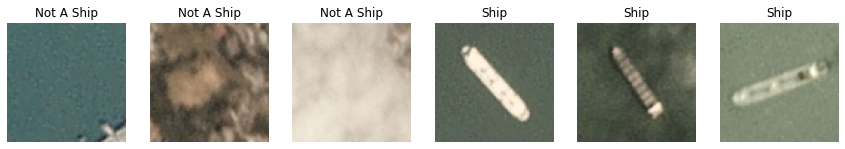

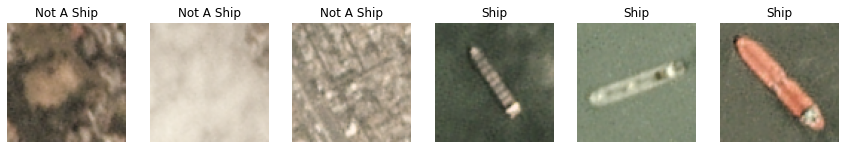

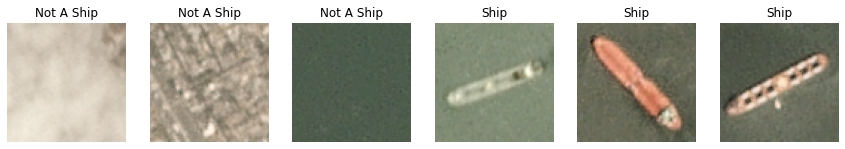

In [36]:
imgs0 = data[y==0] 
imgs1 = data[y==1] 

def plotTwo(a,b): 

    for row in range(3):
        plt.figure(figsize=(20, 10))
        for col in range(3):
            plt.subplot(1,8,col+1)
            plt.title('Not A Ship')
            plt.imshow(a[row+col])
            plt.axis('off')       
            plt.subplot(1,8,col+4)
            plt.title('Ship')
            plt.imshow(b[row+col])
            plt.axis('off')
            
plotTwo(imgs0, imgs1) 

In [12]:
data.shape

(4000, 80, 80, 3)

4000 Images with height and width of 80 and 3 color channels (RGB)

### Converting into Grayscale

The images will be converted to gray scale. i.e. the range of each pixel will be from white to black


In scikit image the grayscale pixel is calculated as the weighted sum of the RGB pixels as:
#### Y = 0.2125 R + 0.7154 G + 0.0721 B




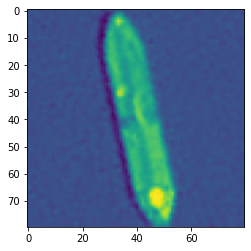

In [13]:
data_gray = [ color.rgb2gray(i) for i in data]
plt.imshow(data_gray[51])

### HOG Features: Histogram of Oriented Gradients

It's a feature descriptor to extract important features from image data.

1. It gives the gradient and the orientation.

2. These two are calculated in localized portions. i.e. The complete image is broken down into smaller regions and for each regions, the gradient and the orientaion is calculated.

3. HOG will generate Histogram for each of the regions separately. These histograms are created using the gradient and orientations of the pixel values. 


#### Calculating gradients in x and y direction:

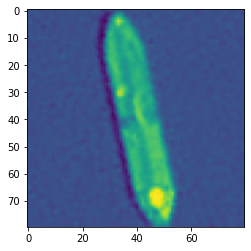

In [14]:
plt.imshow(data_gray[51])

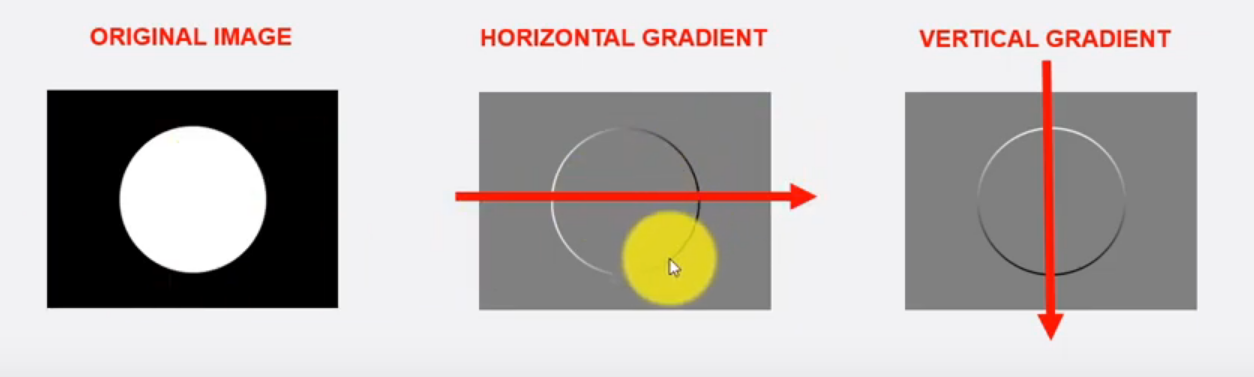

In [10]:
Image(filename='gradient.png')

The gradient in each direction is calculated using changes in the each direction producing two matrices for x and y.

Let's say Gx and Gy be the gradient for each x and y direction. 


Magnitude of the gradient is =  sqrt((Gx)²  + (Gy)²)

Orientation for the same pixel = tan(Φ) = Gy / Gx

Hence the angle Φ can be found from this.

The histogram is plotted using the frequency distribution of the angle or orientation on x-axis and their frequecy on the y-axis.


In [106]:
80/16

5.0

In [15]:
ppc = 8
hog_images = []
hog_features = []
for image in data_gray:
    # orientations -  Number of orientation bins for the histogram
    # pixels_per_cell - Size (in pixels) of a cell.
    # cells_per_block - Number of cells in each block.

    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
    hog_images.append(hog_image)
    hog_features.append(fd)

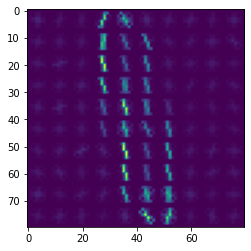

In [16]:
plt.imshow(hog_images[51]) #4*4 cells per block, ppc = 8



The hog function of skimage returns a matrix that can be used to visualize the gradients


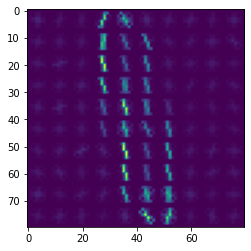

In [17]:
plt.imshow(hog_images[51]) #2*2 cells per block, ppc= 16

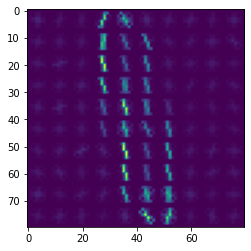

In [18]:
plt.imshow(hog_images[51]) #4*4 cells per block, ppc = 16

In [19]:
labels =  np.array(dataset['labels']).reshape(len(dataset['labels']),1)

In [20]:
labels

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

## SVM Classifier using HOG features

In [23]:
clf = svm.SVC()
hog_features = np.array(hog_features)
data_frame = np.hstack((hog_features,labels))
np.random.shuffle(data_frame)

In [24]:
percentage = 70
partition = int(len(hog_features)*percentage/100)

In [78]:
x_train, x_test = data_frame[:partition,:-1],  data_frame[partition:,:-1]
y_train, y_test = data_frame[:partition,-1:].ravel() , data_frame[partition:,-1:].ravel()

In [81]:
clf.fit(x_train,y_train)

SVC()

In [27]:
y_pred = clf.predict(x_test)

In [28]:
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.9941666666666666


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       906
         1.0       0.99      0.99      0.99       294

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



### Without HOG Features

In [92]:
x = np.array(dataset['data']).astype('uint8')
y = np.array(dataset['labels']).astype('uint8')

In [102]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3 ,random_state = 10)

In [109]:
def compare_models(a,b,c,d):   
    print('\nCompare Multiple Classifiers:')
    print('\nK-Fold Cross-Validation Accuracy:\n')
    models = []
    models.append(('SVM', SVC()))
    models.append(('LR', LogisticRegression()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('LSVM', LinearSVC()))
    models.append(('GNB', GaussianNB()))
    models.append(('DTC', DecisionTreeClassifier()))
    models.append(('XGB', XGBClassifier()))
#     models.append(('GBC', GradientBoostingClassifier()))
#     models.append(('LDA', LinearDiscriminantAnalysis()))  
    resultsAccuracy = []
    names = []
    for name, model in models:
        model.fit(a,b)
        kfold = model_selection.KFold(n_splits=10, random_state=7)
        accuracy_results = model_selection.cross_val_score(model, a,b, cv=kfold, scoring='accuracy')
        resultsAccuracy.append(accuracy_results)
        names.append(name)
        accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
        print(accuracyMessage)
   
    return

In [110]:
compare_models(x_train,y_train,x_test,y_test)


Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:

SVM: 0.963929 (0.011456)
LR: 0.886071 (0.016166)
RF: 0.956071 (0.011742)
KNN: 0.924643 (0.020482)
LSVM: 0.887857 (0.019833)
GNB: 0.625357 (0.023552)
DTC: 0.895000 (0.019113)
[13:37:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting i